In [5]:
import pandas as pd
import json
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import random
import re
import time
import matplotlib.pyplot as plt
import networkx as nx

import tweepy
import jsonpickle
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams['savefig.dpi'] = 500 #图片像素
rcParams['figure.dpi'] = 500

# Data collection

In [6]:
def parse_tweets_data(data):
    
    created_at = data["created_at"]
    tweet_id = data['id']
    text = data['full_text']
    text_len = len(text)
    
    user_id = data['user']['id']
    user_name = data['user']['name']
    user_screen_name = data['user']['screen_name']
    user_location = data['user']['location']
    user_description = data['user']['description']
    user_friends = data['user']['friends_count']
    user_follower = data['user']['followers_count']
    hashtags = []
    for h in data['entities']['hashtags']:
        hashtags.append(h['text'])
    
    user_mentions = []
    for u in data['entities']['user_mentions']:
        user_mentions.append(u['id'])
    
    retweet_count = data['retweet_count']
    favorite_count = data['favorite_count']
    lang = data['lang']
    
    rt_created_at = ""
    rt_tweet_id = ""
    rt_user_id = ""
    rt_user_name = ""
    rt_user_screen_name = ""
    rt_user_location = ""
    rt_user_description = ""
    rt_user_friends = ""
    rt_user_follower = ""
    
    rt_retweet_count = ""
    rt_favorite_count =""
    rt_lang =""
    is_retweet =False
    if text[:4]=='RT @':
        is_retweet = True
    
    
    ## parse retweeted_status
    try:
        if is_retweet is True:
        ##print (tweets_id)
            rt_created_at = data['retweeted_status']['created_at']
            rt_tweet_id = data['retweeted_status']['id']
            rt_user_id = data['retweeted_status']['user']['id']
            rt_user_name = data['retweeted_status']['user']['name']
            rt_user_screen_name = data['retweeted_status']['user']['screen_name']
            rt_user_location = data['retweeted_status']['user']['location']
            rt_user_description = data['retweeted_status']['user']['description']
            rt_user_friends = data['retweeted_status']['user']['friends_count']
            rt_user_follower = data['retweeted_status']['user']['followers_count']
    
            rt_retweet_count = data['retweeted_status']['retweet_count']
            rt_favorite_count = data['retweeted_status']['favorite_count']
            rt_lang = data['retweeted_status']['lang']

    except Exception as e:
        print (tweet_id," ",e)
        
    param = [created_at,tweet_id,hashtags,text,text_len,user_id,user_name,user_screen_name,user_location,user_description,user_friends,user_follower,user_mentions,retweet_count,favorite_count,lang,is_retweet,rt_created_at,rt_tweet_id,rt_user_id,rt_user_name,rt_user_screen_name,rt_user_location,rt_user_description,rt_user_friends,rt_user_follower,rt_retweet_count,rt_favorite_count,rt_lang]

    return param

In [8]:
# Read my twitter developer keys
# config = pd.read_csv('./config.csv')

consumer_key = "yEdCvMxttz8LTusf6yldrzixI"  # config["consumer_key"][0]
# config["consumer_secret"][0]
consumer_secret = "vNNAX4QrF0VVdqhQsUsxMb9EWibKlHkpF5JeqOY3PhZkUxERIc"
# config["access_token"][0]
access_token = "965236314672164864-TKpodRBudpVhnXRvoiE0QiM3XVdfEIO"
# config["access_token_secret"][0]
access_token_secret = "EVMzWs7JGq2POpu7okReSeUIo9h35B7dT8spMe7uOORKN"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)


api = tweepy.API(auth, proxy="127.0.0.1:10809", wait_on_rate_limit=True)

if (not api):
    print("Problem connection to API")
else:
    print("Connection is ok")


# search keywords from tweets of past 30 days
# searchQuery = "(BillieEilish OR Billiee OR @Billiee) AND Vogue"
searchQuery = "WWDC21"

maxTweets = 1500
tweetCount = 0
tweets = []

# Open a text file to save the tweets to
with open('tweets.json', 'w') as f:

    # Tell the Cursor method that we want to use the Search API (api.search)
    # Also tell Cursor our query, and the maximum number of tweets to return
    for tweet in tweepy.Cursor(api.search,q=searchQuery, tweet_mode="extended").items(maxTweets) :         
        #Write the JSON format to the text file, and add one to the number of tweets we've collected
        data = parse_tweets_data(tweet._json)
        tweets.append(data)
        f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
        tweetCount += 1
        print(tweetCount)
    # Display how many tweets we have collected
    print("Downloaded {0} tweets".format(tweetCount))


Connection is ok
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273

In [9]:
columns = "created_at,tweet_id,hashtags,text,text_len,user_id,user_name,user_screen_name,user_location,user_description,user_friends,user_follower,user_mentions,retweet_count,favorite_count,lang,is_retweet,rt_created_at,rt_tweet_id,rt_user_id,rt_user_name,rt_user_screen_name,rt_user_location,rt_user_description,rt_user_friends,rt_user_follower,rt_retweet_count,rt_favorite_count,rt_lang".split(
    ',')
df = pd.DataFrame(data=tweets, columns=columns)
df.head(5)

,created_at,tweet_id,hashtags,text,text_len,user_id,user_name,user_screen_name,user_location,user_description,...,rt_user_id,rt_user_name,rt_user_screen_name,rt_user_location,rt_user_description,rt_user_friends,rt_user_follower,rt_retweet_count,rt_favorite_count,rt_lang
0,Mon Jun 07 20:10:44 +0000 2021,1401995056802942983,[WWDC21],It's probably all the excitement about #WWDC21 :),49,1032921437387022336,Marko Zivanovic,markozivan0vic,,I do code. I mostly tweet about things that an...,...,,,,,,,,,,
1,Mon Jun 07 20:10:43 +0000 2021,1401995055762755584,"[WWDC21, iOS15]",Let’s go! iOS 15.0 Developer Beta 1 (19A5261w)...,85,789915464,Joan Cama,joankmr,Girona,Web & Graphic Designer | iMac 5k / MBP 13” / i...,...,,,,,,,,,,
2,Mon Jun 07 20:10:43 +0000 2021,1401995055527710725,[WWDC21],RT @insanetweet: iPhone 6s while upgrading to ...,84,3962902935,abdi 🧔🏿,Akay1050,Searching...,sirina bail money 🤗,...,800020073276653569,Anti,insanetweet,,,152,54,74,435,en
3,Mon Jun 07 20:10:43 +0000 2021,1401995054126936064,[],RT @Tecnoblog: A nova função SharePlay permite...,140,2386062695,andressa,anndrssa,"slz, maranhão",feita de palhaça pelo flamengo,...,16008305,Tecnoblog,Tecnoblog,Brasil,"Tecnologia que interessa. Reportagens, podcast...",26,325771,7,40,pt
4,Mon Jun 07 20:10:43 +0000 2021,1401995053732671496,[wwdc21],So many interesting #wwdc21 sessions and so li...,57,41357102,Donny Wals 👾,DonnyWals,The Netherlands,Passionate iOS developer at Disney Streaming S...,...,,,,,,,,,,


In [10]:
import pymongo

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
DBName = "twitter_content"
ColName = "WWDC21"

mydb = myclient[DBName]
mycol = mydb[ColName]
#判断DB是否存在
dblist = myclient.list_database_names()
# dblist = myclient.database_names() 
if DBName in dblist:
    print("数据库已存在！")
    
else:
    print("新建数据库twitter_content")

    
# 判断集合是否存在    
collist = mydb.list_collection_names()
if ColName in collist:   
  print("集合已存在！")



docs = mycol.find()
tweet_ids = []
for doc in docs:
    tweet_ids.append(doc['tweet_id'])
print('all len is ', len(tweet_ids))
print('unique len is ', len(set(tweet_ids)))

data = df.to_dict('records')
arr = []
for line in data:
    if line['tweet_id'] in tweet_ids:
        continue
    tweet_ids.append(line['tweet_id'])
    one = pymongo.UpdateOne(line, {'$setOnInsert': line}, upsert=True)
    arr.append(one)
    if len(arr) == 10000:
        mycol.bulk_write(arr)
        arr = []
        print("writen ", 10000, ' line.')
if len(arr) != 0:
    mycol.bulk_write(arr)
    print("writen ", len(arr), ' line.')


数据库已存在！
集合已存在！
all len is  1500
unique len is  1500
writen  1500  line.


# Compute Popularity
## PageRank popularity
输入 input_1.txt形如：

B A

C A

D A

表示前者指向后者

In [41]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
DBName = "twitter_content"
ColName = "WWDC21"

mydb = myclient[DBName]
mycol = mydb[ColName]
#判断DB是否存在
dblist = myclient.list_database_names()
# dblist = myclient.database_names() 
if DBName in dblist:
    print("数据库已存在！")
    
else:
    print("新建数据库twitter_content")

    
# 判断集合是否存在    
collist = mydb.list_collection_names()
if ColName in collist:   
    print("集合已存在！")

docs = mycol.find()
id_edges = []
edges = []
for doc in docs:
    if doc['is_retweet']:
        id_edges.append([doc['tweet_id'], doc['rt_tweet_id']])
        edges.append([doc['tweet_id'], doc['rt_tweet_id']])
# 读入有向图，存储边
# f = open('input.txt', 'r')
# id_edges = [line.strip('\n').split(' ') for line in f]
# print(id_edges)

# 根据边获取节点的集合
nodes = []
for edge in edges:
    if edge[0] not in nodes:
        nodes.append(edge[0])
    if edge[1] not in nodes:
        nodes.append(edge[1])
print('nodes :', nodes)

N = len(nodes)

# 将节点符号（字母），映射成阿拉伯数字，便于后面生成A矩阵/S矩阵
i = 0
node_to_num = {}
for node in nodes:
    node_to_num[node] = i
    i += 1
for edge in edges:
    edge[0] = node_to_num[edge[0]]
    edge[1] = node_to_num[edge[1]]
print('edges :', edges)

# 生成初步的S矩阵
S = np.zeros([N, N])
for edge in edges:
    S[edge[1], edge[0]] = 1
print('S - before :', S)

# 计算比例：即一个网页对其他网页的PageRank值的贡献，即进行列的归一化处理
for j in range(N):
    sum_of_col = S[:,j].sum()
    if sum_of_col != 0:
        for i in range(N):
            S[i, j] /= sum_of_col
print('S - after :',S)

# 计算矩阵A
alpha = 0.85
A = alpha*S + (1-alpha) / N * np.ones([N, N])
print('A :', A)

# 生成初始的PageRank值，记录在P_n中，P_n和P_n1均用于迭代
P_n = np.ones(N) / N
# P_n1 = np.zeros(N)


e = 100000  # 误差初始化
k = 0   # 记录迭代次数
print('loop...')

while e > 0.00000001:   # 开始迭代
    P_n = P_n1 if k != 0 else P_n
    P_n1 = np.dot(A, P_n)   # 迭代公式
    sum_of_P = P_n1.sum()
    P_n1 = P_n1/sum_of_P
#     P_n = P_n1
    k += 1
    e = P_n1-P_n
    e = max(map(abs, e))    # 计算误差
    print('e :', e)
    print('iteration %s:'%str(k), P_n1)

print('final result:', P_n)

数据库已存在！
集合已存在！
nodes : [1401985419684634625, 1401968570901229568, 1401985419609362433, 1401969557527539716, 1401985419135311872, 1401957928672837641, 1401985416597749770, 1401955387688034304, 1401985415691702272, 1401977157857910796, 1401985415368777729, 1401952865254477824, 1401985413212819457, 1401985413045055488, 1401955885199499264, 1401985412264988673, 1401973485640032256, 1401985412059463680, 1401974070418284550, 1401985411266727939, 1401976131667042306, 1401985411258339328, 1401985411178631170, 1401985411023474689, 1401985410893443073, 1401976970477457412, 1401985410864074756, 1401977090329747469, 1401985410364952577, 1401983593707184131, 1401985410113294336, 1401982139076317189, 1401985410083954688, 1401979591057571840, 1401985409807122434, 1401984912677347332, 1401985409756786690, 1401984366453035008, 1401985405092831236, 1401973481592524810, 1401985405038120960, 1401983706777088001, 1401985404841173001, 1401962296277094403, 1401985403863896064, 1401954997168975876, 1401985399

S - after : [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
A : [[4.91642085e-05 4.91642085e-05 4.91642085e-05 ... 4.91642085e-05
  4.91642085e-05 4.91642085e-05]
 [8.50049164e-01 4.91642085e-05 4.91642085e-05 ... 4.91642085e-05
  4.91642085e-05 4.91642085e-05]
 [4.91642085e-05 4.91642085e-05 4.91642085e-05 ... 4.91642085e-05
  4.91642085e-05 4.91642085e-05]
 ...
 [4.91642085e-05 4.91642085e-05 4.91642085e-05 ... 4.91642085e-05
  4.91642085e-05 4.91642085e-05]
 [4.91642085e-05 4.91642085e-05 4.91642085e-05 ... 4.91642085e-05
  4.91642085e-05 4.91642085e-05]
 [4.91642085e-05 4.91642085e-05 4.91642085e-05 ... 4.91642085e-05
  4.91642085e-05 4.91642085e-05]]
loop...
e : 0.03361790820866252
iteration 1: [6.49885187e-05 2.64286643e-03 6.49885187e-05 ... 6.49885187e-05
 6.49885187e-05 6.49885187e-05]
e : 0.014959122349068557
iteration 2: [0.00018192 0.0016127  0.00018192 ... 0.00018192

In [42]:
PR = dict(zip(nodes, P_n))

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


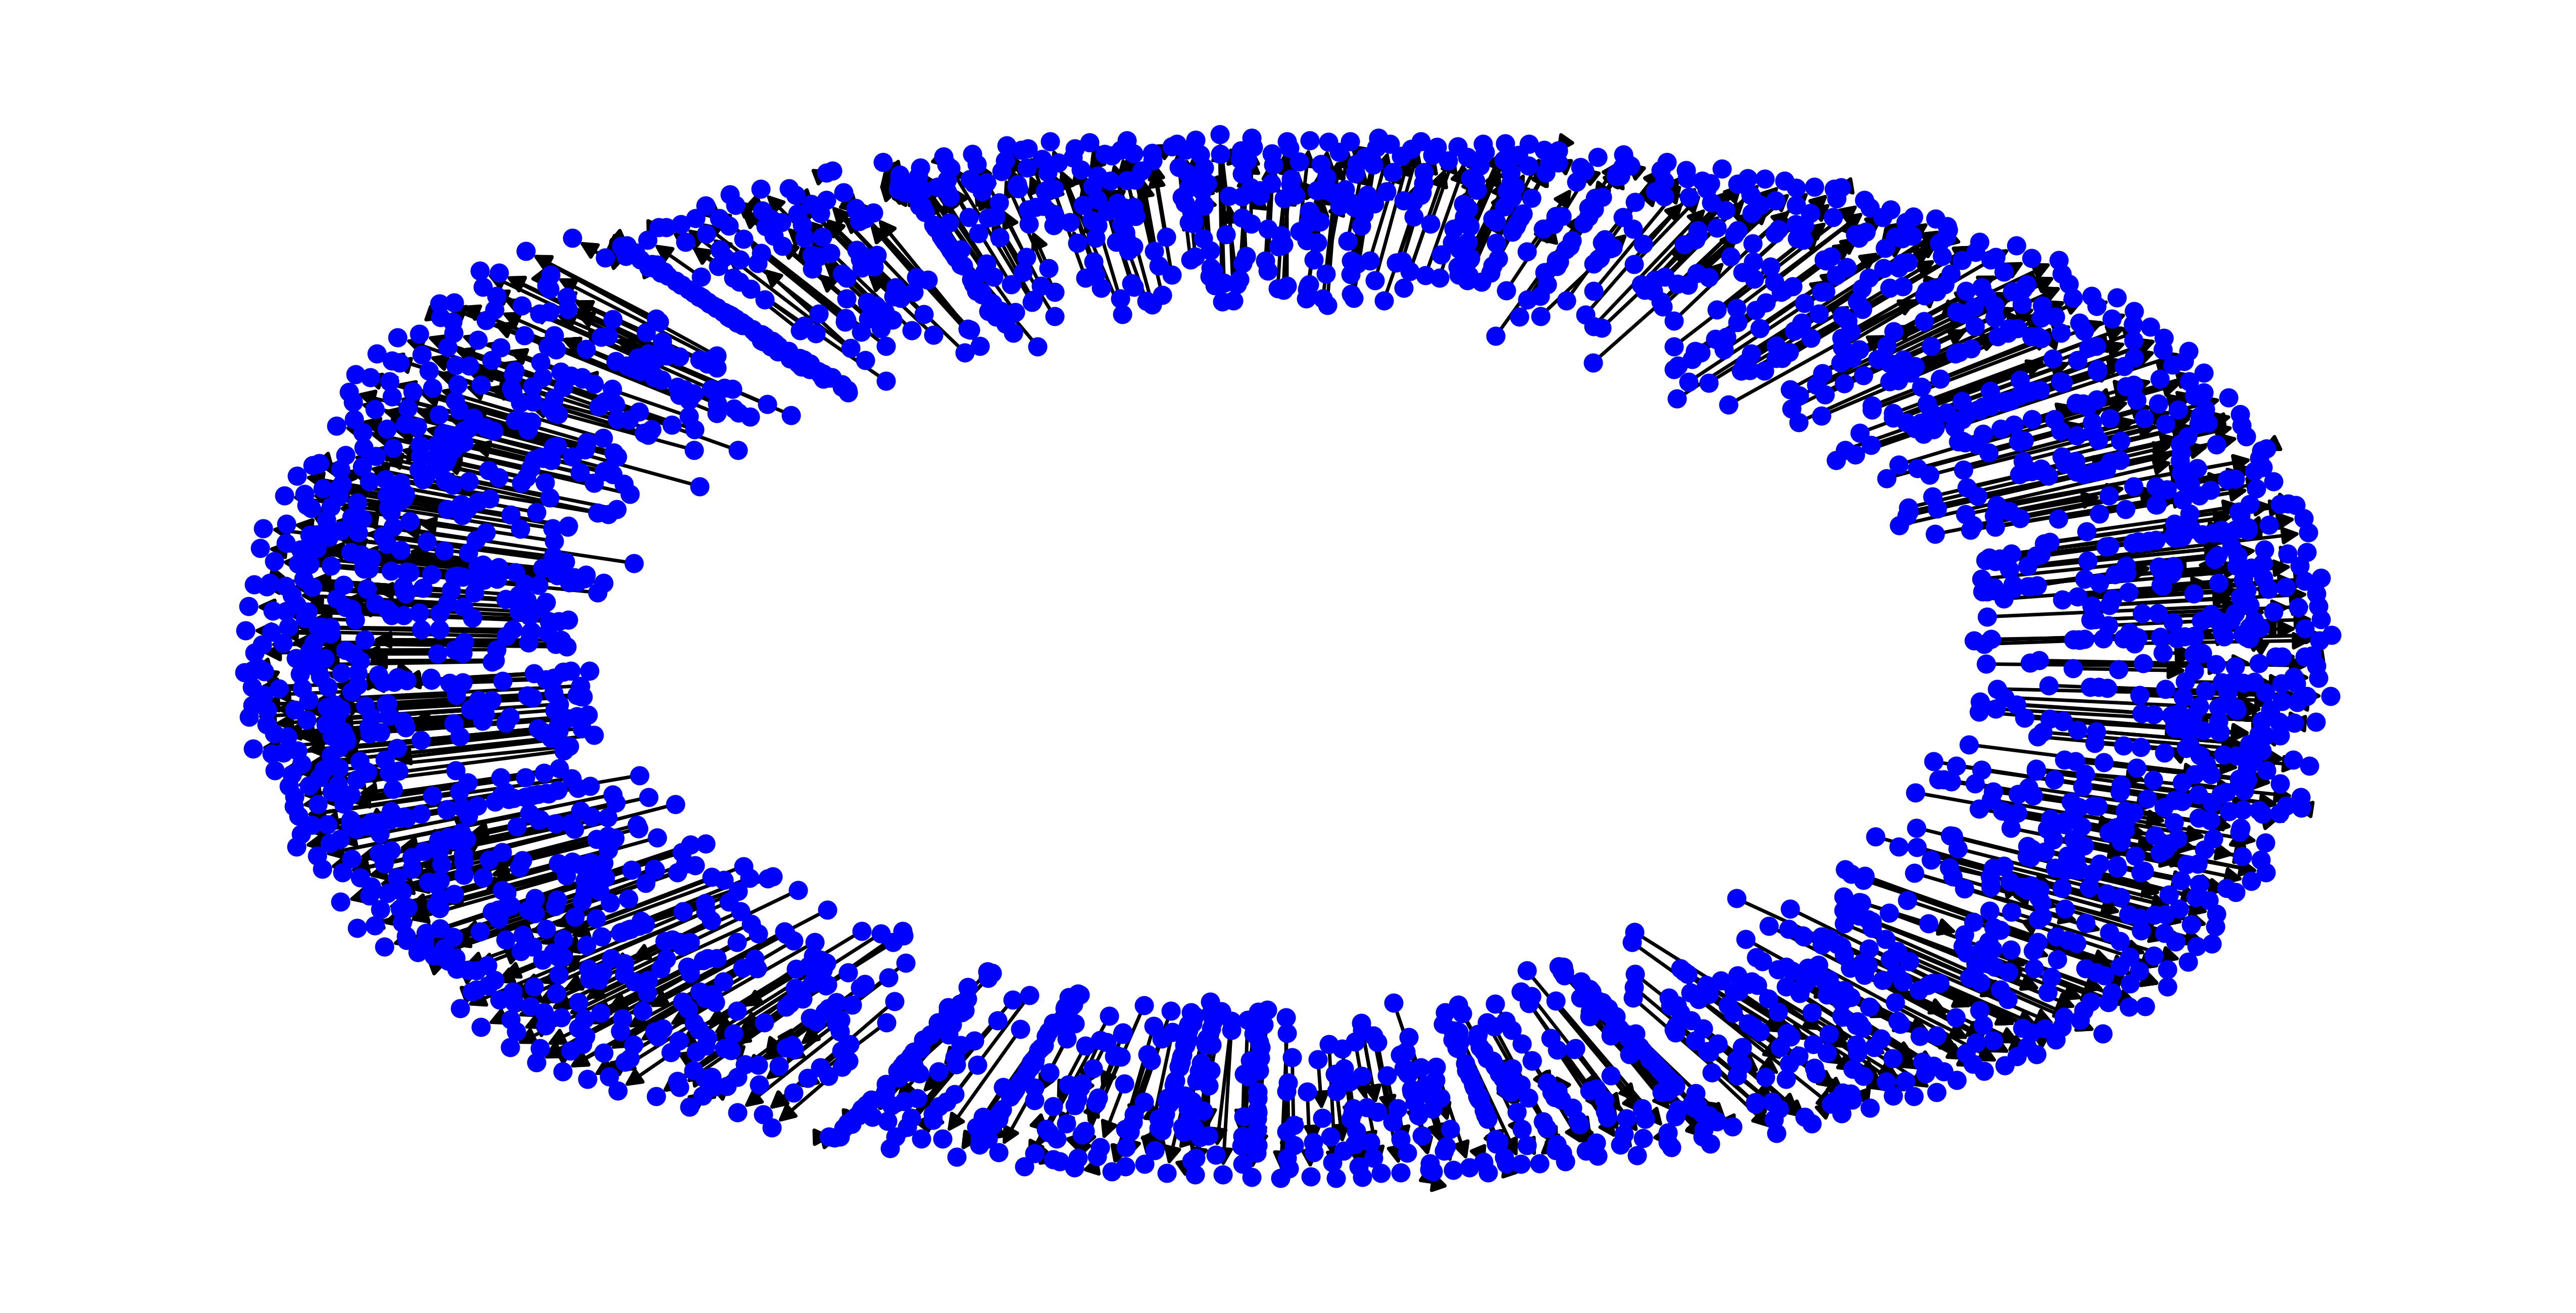

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

options = {
    'node_color': 'blue',
    'node_size': 20,
}
G = nx.DiGraph()
for edge in edges:
    G.add_edge(edge[0], edge[1])
nx.draw(G, with_labels=False, **options)
plt.show()

## Popularity Score Fomula

In [16]:
# query the popularity of user
def query_followers(user_id):
    return api.get_user(839126971)._json['followers_count']
   
def Cal_state_popularity(tweet_id, created_time, user_mentions, user_followers_count, user_friends_count,
                   retweet_FLAG, favourites_count, retweet_count):
    
    #initial score from both content attri & user basis(or user-mentions)
#     S_0 = user_followers_count//20 + user_friends_count//50
    S_0 = user_followers_count//20 + user_friends_count//50
    if len(user_mentions) > 0:
        for j in range(len(user_mentions)):
            #query the followers of users mentioned
            S_0 += 0.01*query_followers(j)
            
            
    #score from user interactions like 
    S_1 = 1*favourites_count + 4*retweet_count
#     if reply_FLAG:
#         S_1 += 1
        
    #score from PageRank(the graph network)
    #PR_result need to be computed before this function work! and its form in dict
    #eg. PR_result["#tweet_id"] = the pr value
    S_2 = 0
    if tweet_id in nodes:
        S_2 += 100*PR[tweet_id]
    return S_0+S_1+S_2


In [21]:
# import pymongo
# myclient = pymongo.MongoClient("mongodb://localhost:27017/")
# DBName = "twitter_content"
# ColName = "WWDC21"

# mydb = myclient[DBName]
# mycol = mydb[ColName]


docs = mycol.find({'popularity_state':{ '$exists': False}})
for doc in docs:
#     if doc['popularity_state'] == None:
    p_state = Cal_state_popularity(doc['tweet_id'],doc['created_at'], doc['user_mentions'],
               doc['user_follower'], doc['user_friends'], 
                doc['is_retweet'], doc['favorite_count'],
               doc['retweet_count'])
    mycol.update_one({"_id": doc["_id"]}, {"$set": {"popularity_state": p_state}})
    mycol.update_one({"_id": doc["_id"]}, {"$set": {"popularity_mobile": p_state}})
    


In [55]:
import datetime

#根据牛顿冷却公式: 假设初始热度为100,而设定周期=30天后热度下降至1,则计算得到冷却系数 k_time
k_time = - np.log(0.01)/30
#冷却公式
def Decay(gap):
    # gap正负兼容
    return np.exp(-k_time * abs(gap))
#TODO: query the created time of original tweets
def query_time(tweet_id):
    time = mycol.find_one({"tweet_id": tweet_id})['created_at']
    b = datetime.datetime.strptime(time, '%a %b %d %H:%M:%S %z %Y')
    return b
 

for pair in id_edges:
    if mycol.find_one({"tweet_id": pair[1]}):
        delta = query_time(pair[0]) - query_time(pair[1])
        x = mycol.find_one({"tweet_id": pair[1]})['popularity_state'] + mycol.find_one({"tweet_id": pair[0]})['popularity_state']*Decay(delta.days)
        mycol.update({"tweet_id": pair[1]}, {"$set": {"popularity_mobile": x}})

@
@
@


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@
@


In [52]:
 mycol.find_one({"tweet_id": 0 })

# Data Exploration

In [59]:
len(edges)

2177

In [64]:
len(P_n)

3051